# Add Advanced Features for LSTM

This notebook adds advanced technical and temporal features to the LSTM-ready data:
- Cyclical time encoding (4 features)
- Gap features from data cleaning (3 features: gap_days, post_weekend, post_holiday)
- Price returns (2 features)
- Volatility measures (1 feature)
- Technical momentum (1 feature)
- Volume analysis (1 feature)

Note: Using trading-only data, so no need for days_since_trade feature

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load LSTM-age-added Data

In [2]:
# Load the data with age features
data_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_df = pd.read_parquet(os.path.join(data_dir, "HBEA_LSTM_age_added.parquet"))
gdea_df = pd.read_parquet(os.path.join(data_dir, "GDEA_LSTM_age_added.parquet"))

print(f"HBEA shape: {hbea_df.shape}")
print(f"GDEA shape: {gdea_df.shape}")
print(f"\nData range: {hbea_df.index.min()} to {hbea_df.index.max()}")
print(f"\nSample columns (first 10): {list(hbea_df.columns[:10])}")

HBEA shape: (2679, 48)
GDEA shape: (2638, 48)

Data range: 2014-04-28 00:00:00 to 2025-05-06 00:00:00

Sample columns (first 10): ['close', 'vwap', 'volume_tons', 'turnover_cny', 'cum_turnover_cny', 'is_open', 'is_quiet', 'has_trade', 'gap_days', 'post_weekend']


## 2. Verify Data Structure

In [3]:
# Understand the trading flags
print("=== Trading Flags Analysis ===")
print(f"has_trade value counts:\n{hbea_df['has_trade'].value_counts()}")
print(f"\nis_open value counts:\n{hbea_df['is_open'].value_counts()}")
print(f"\nis_quiet value counts:\n{hbea_df['is_quiet'].value_counts()}")

# Verify relationships
quiet_days = hbea_df[hbea_df['is_quiet'] == True]
print(f"\nQuiet days check:")
print(f"  All quiet days have is_open=True: {(quiet_days['is_open'] == True).all()}")
print(f"  All quiet days have has_trade=False: {(quiet_days['has_trade'] == False).all()}")

=== Trading Flags Analysis ===
has_trade value counts:
has_trade
True     2610
False      69
Name: count, dtype: int64

is_open value counts:
is_open
True    2679
Name: count, dtype: int64

is_quiet value counts:
is_quiet
False    2610
True       69
Name: count, dtype: int64

Quiet days check:
  All quiet days have is_open=True: True
  All quiet days have has_trade=False: True


## 3. Feature Engineering Functions

In [4]:
def add_cyclical_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclical encoding for day of week and month.
    """
    df = df.copy()
    
    # Day of week encoding (0=Monday, 6=Sunday)
    df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Month encoding (1-12 mapped to 0-11 for calculation)
    df['month_sin'] = np.sin(2 * np.pi * (df.index.month - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df.index.month - 1) / 12)
    
    return df


def add_return_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add log returns and 5-day returns.
    """
    df = df.copy()
    
    # Daily log returns
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # 5-day percentage returns (5 TRADING days with trading-only data)
    df['return_5d'] = df['close'].pct_change(5)
    
    return df


def add_volatility_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Bollinger Band width as volatility measure.
    """
    df = df.copy()
    
    # 20-day rolling statistics (20 TRADING days)
    sma20 = df['close'].rolling(20, min_periods=1).mean()
    std20 = df['close'].rolling(20, min_periods=1).std()
    
    # Bollinger bands
    upper_band = sma20 + 2 * std20
    lower_band = sma20 - 2 * std20
    
    # Normalized width (handle division by zero)
    df['bb_width'] = (upper_band - lower_band) / sma20.replace(0, np.nan)
    
    return df


def add_momentum_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add RSI (Relative Strength Index) indicator.
    """
    df = df.copy()
    
    # Calculate price changes
    delta = df['close'].diff()
    
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = (-delta.clip(upper=0))
    
    # Use exponential weighted mean (Wilder's smoothing)
    # For 14-day RSI, use com=13 (equivalent to alpha=1/14)
    avg_gain = gain.ewm(com=13, adjust=False, min_periods=14).mean()
    avg_loss = loss.ewm(com=13, adjust=False, min_periods=14).mean()
    
    # Calculate RSI
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    return df


def add_volume_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add volume moving average.
    """
    df = df.copy()
    
    # 20-day simple moving average of volume (20 TRADING days)
    df['volume_sma_20'] = df['volume_tons'].rolling(20, min_periods=1).mean()
    
    return df

# Note: Removed add_market_state_features() as days_since_trade is meaningless with trading-only data

## 4. Apply All Feature Engineering

In [5]:
def add_all_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all feature engineering functions in sequence.
    Note: Using trading-only data, so no market state features needed.
    """
    print("Adding cyclical time features...")
    df = add_cyclical_time_features(df)
    
    # REMOVED: add_market_state_features (meaningless with trading-only data)
    
    print("Adding return features...")
    df = add_return_features(df)
    
    print("Adding volatility features...")
    df = add_volatility_features(df)
    
    print("Adding momentum features...")
    df = add_momentum_features(df)
    
    print("Adding volume features...")
    df = add_volume_features(df)
    
    # Add gap features that were preserved from data cleaning
    print("Gap features (gap_days, post_weekend, post_holiday) already in data from cleaning step")
    
    return df

# Process both datasets
print("Processing HBEA data...")
hbea_advanced = add_all_advanced_features(hbea_df)

print("\nProcessing GDEA data...")
gdea_advanced = add_all_advanced_features(gdea_df)

print(f"\nFinal shapes:")
print(f"HBEA: {hbea_advanced.shape}")
print(f"GDEA: {gdea_advanced.shape}")

Processing HBEA data...
Adding cyclical time features...
Adding return features...
Adding volatility features...
Adding momentum features...
Adding volume features...
Gap features (gap_days, post_weekend, post_holiday) already in data from cleaning step

Processing GDEA data...
Adding cyclical time features...
Adding return features...
Adding volatility features...
Adding momentum features...
Adding volume features...
Gap features (gap_days, post_weekend, post_holiday) already in data from cleaning step

Final shapes:
HBEA: (2679, 57)
GDEA: (2638, 57)


## 5. Quality Checks

In [6]:
# List new features (removed days_since_trade as it's meaningless with trading-only data)
new_features = [
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'log_return', 'return_5d',
    'bb_width', 'rsi_14', 'volume_sma_20'
]

print("=== Quality Checks ===")
print("\n1. Cyclical features range check:")
for feat in ['dow_sin', 'dow_cos', 'month_sin', 'month_cos']:
    if feat in hbea_advanced.columns:
        min_val = hbea_advanced[feat].min()
        max_val = hbea_advanced[feat].max()
        print(f"  {feat}: min={min_val:.3f}, max={max_val:.3f} (should be in [-1, 1])")

print("\n2. Gap features check (from data cleaning):")
print(f"  Gap days present: {'gap_days' in hbea_advanced.columns}")
print(f"  Post weekend present: {'post_weekend' in hbea_advanced.columns}")
print(f"  Post holiday present: {'post_holiday' in hbea_advanced.columns}")
if 'gap_days' in hbea_advanced.columns:
    print(f"  Max gap between trading days: {hbea_advanced['gap_days'].max()} days")
    print(f"  Weekend gaps (3 days): {(hbea_advanced['gap_days'] == 3).sum()}")
    print(f"  Holiday gaps (>3 days): {(hbea_advanced['gap_days'] > 3).sum()}")

print("\n3. RSI bounds check:")
if 'rsi_14' in hbea_advanced.columns:
    rsi_vals = hbea_advanced['rsi_14'].dropna()
    print(f"  RSI range: {rsi_vals.min():.2f} to {rsi_vals.max():.2f} (should be in [0, 100])")

print("\n4. NaN counts for new features:")
for feat in new_features:
    if feat in hbea_advanced.columns:
        nan_count = hbea_advanced[feat].isna().sum()
        print(f"  {feat}: {nan_count} NaNs")

=== Quality Checks ===

1. Cyclical features range check:
  dow_sin: min=-0.434, max=0.975 (should be in [-1, 1])
  dow_cos: min=-0.901, max=1.000 (should be in [-1, 1])
  month_sin: min=-1.000, max=1.000 (should be in [-1, 1])
  month_cos: min=-1.000, max=1.000 (should be in [-1, 1])

2. Gap features check (from data cleaning):
  Gap days present: True
  Post weekend present: True
  Post holiday present: True
  Max gap between trading days: 11 days
  Weekend gaps (3 days): 492
  Holiday gaps (>3 days): 72

3. RSI bounds check:
  RSI range: 8.62 to 92.52 (should be in [0, 100])

4. NaN counts for new features:
  dow_sin: 0 NaNs
  dow_cos: 0 NaNs
  month_sin: 0 NaNs
  month_cos: 0 NaNs
  log_return: 1 NaNs
  return_5d: 5 NaNs
  bb_width: 1 NaNs
  rsi_14: 14 NaNs
  volume_sma_20: 0 NaNs


## 6. Verify Gap Features from Data Cleaning

In [7]:
# Sample period to verify gap features (preserved from data cleaning)
sample_cols = ['close', 'volume_tons', 'has_trade', 'gap_days', 'post_weekend', 'post_holiday']
available_cols = [col for col in sample_cols if col in hbea_advanced.columns]
sample_period = hbea_advanced[available_cols].iloc[100:120]

print("Sample of gap features (from data cleaning):")
print(sample_period)
print("\nNote: With trading-only data:")
print("  - gap_days shows calendar days between consecutive trading days")
print("  - post_weekend=True for Mondays after weekends (gap_days=3)")
print("  - post_holiday=True for days after long holidays (gap_days>3)")
print("  - These features capture weekend/holiday effects without keeping non-trading days")

Sample of gap features (from data cleaning):
            close  volume_tons  has_trade  gap_days  post_weekend  \
date                                                                
2014-09-19  24.20      20700.0       True         1         False   
2014-09-22  24.50      11740.0       True         3          True   
2014-09-23  24.52      27371.0       True         1         False   
2014-09-24  24.48      16301.0       True         1         False   
2014-09-25  24.50      10368.0       True         1         False   
2014-09-26  24.58      11129.0       True         1         False   
2014-09-29  24.85      31227.0       True         3          True   
2014-09-30  24.99      47251.0       True         1         False   
2014-10-08  25.11      14428.0       True         8         False   
2014-10-09  25.24      10121.0       True         1         False   
2014-10-10  25.79      22004.0       True         1         False   
2014-10-13  25.30       5927.0       True         3       

## 7. Feature Statistics

In [8]:
# Generate summary statistics for new features
stats_df = hbea_advanced[new_features].describe()
print("=== New Feature Statistics (HBEA) ===")
print(stats_df.round(3))

# Also show gap features statistics
gap_features = ['gap_days', 'post_weekend', 'post_holiday']
available_gap_features = [f for f in gap_features if f in hbea_advanced.columns]
if available_gap_features:
    print("\n=== Gap Features Statistics (from data cleaning) ===")
    gap_stats = hbea_advanced[available_gap_features].describe()
    print(gap_stats.round(3))

=== New Feature Statistics (HBEA) ===
        dow_sin   dow_cos  month_sin  month_cos  log_return  return_5d  \
count  2679.000  2679.000   2679.000   2679.000    2678.000   2674.000   
mean      0.358    -0.083     -0.001     -0.018       0.000      0.002   
std       0.514     0.775      0.703      0.711       0.027      0.055   
min      -0.434    -0.901     -1.000     -1.000      -0.197     -0.398   
25%       0.000    -0.901     -0.500     -0.866      -0.009     -0.017   
50%       0.434    -0.223      0.000      0.000       0.000     -0.000   
75%       0.782     0.623      0.866      0.500       0.009      0.018   
max       0.975     1.000      1.000      1.000       0.111      0.444   

       bb_width    rsi_14  volume_sma_20  
count  2678.000  2665.000       2679.000  
mean      0.130    50.288      37237.082  
std       0.117    10.865      48156.086  
min       0.000     8.617          0.000  
25%       0.062    44.816       6463.325  
50%       0.100    49.711      16309.

## 8. Visualizations

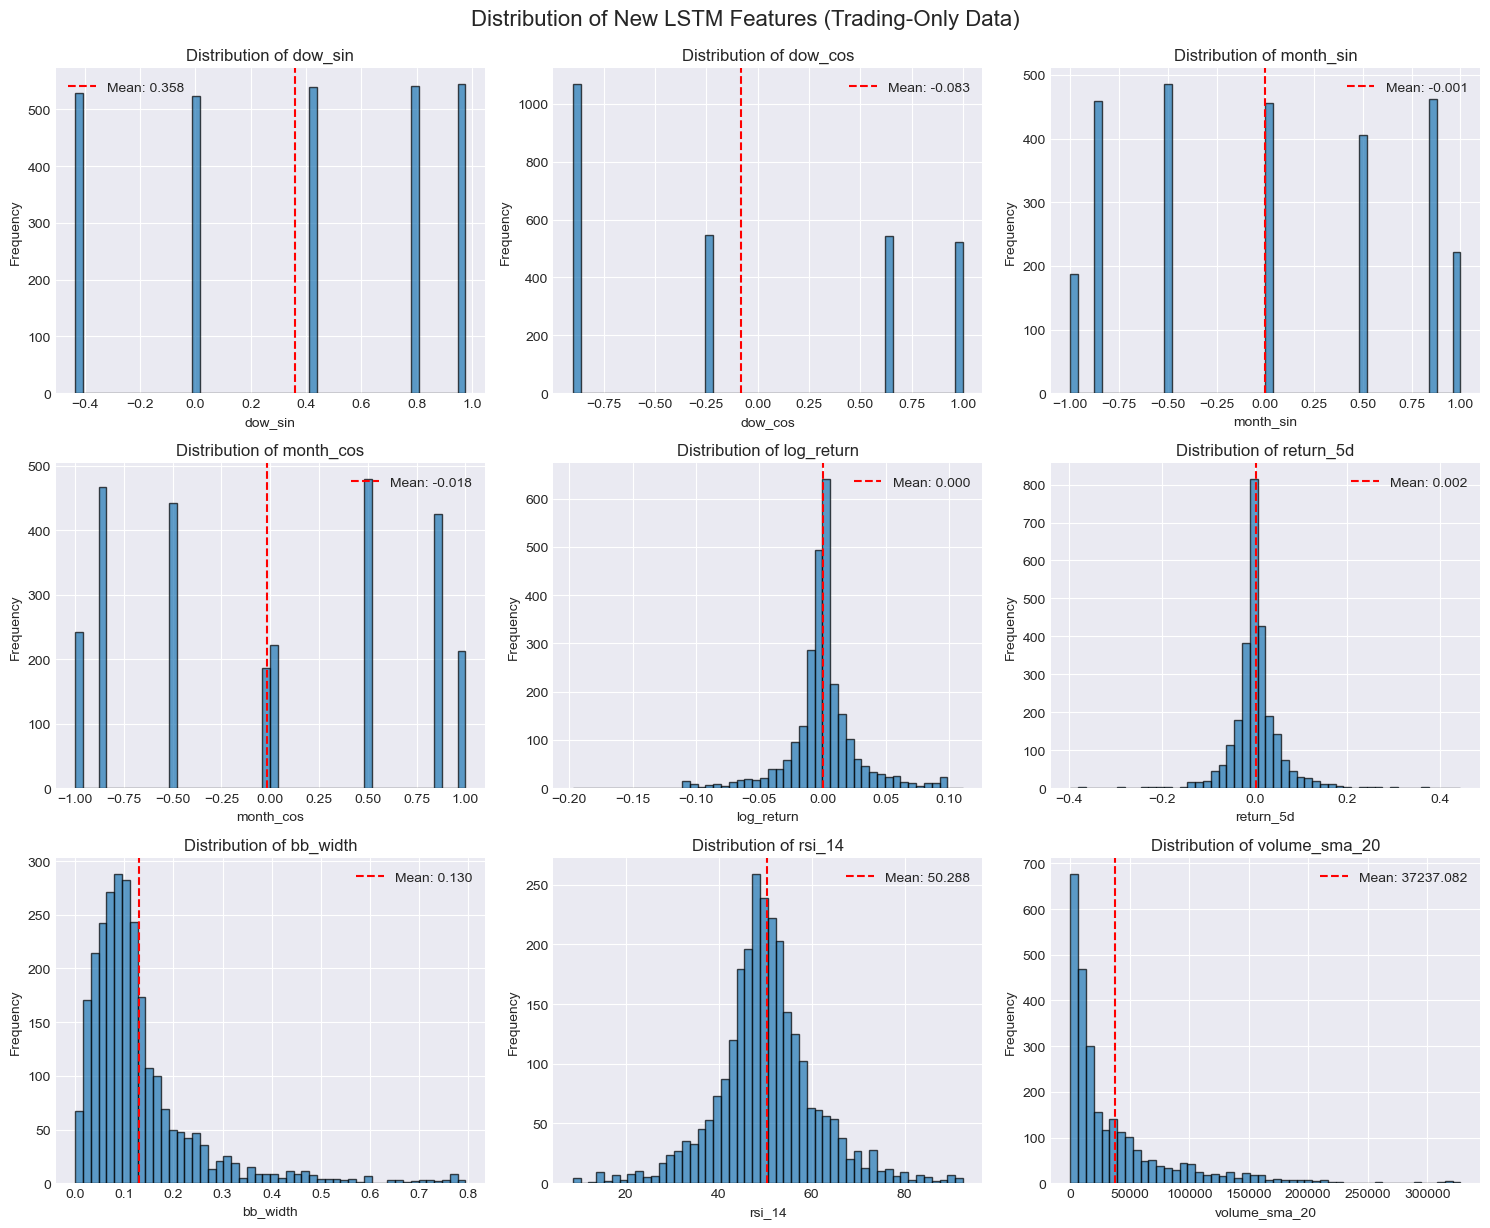

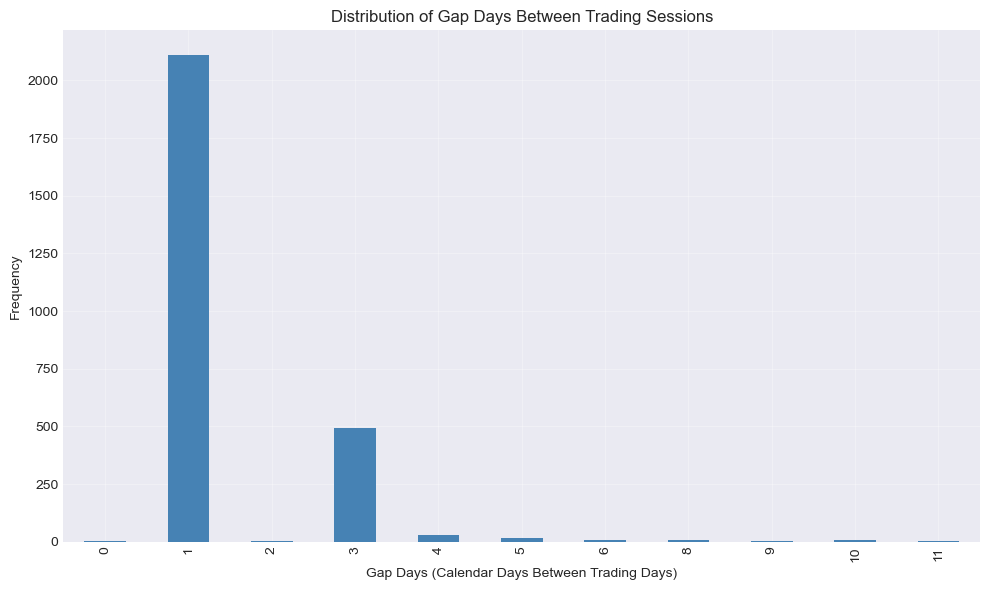

In [9]:
# Create visualizations for new features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feat in enumerate(new_features):
    if idx < len(axes):
        ax = axes[idx]
        if feat in hbea_advanced.columns:
            data = hbea_advanced[feat].dropna()
            
            # Use histogram for all features (no discrete days_since_trade anymore)
            ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
            ax.set_title(f'Distribution of {feat}')
            ax.set_xlabel(feat)
            ax.set_ylabel('Frequency')
            ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
            ax.legend()

# Remove empty subplots
for idx in range(len(new_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Distribution of New LSTM Features (Trading-Only Data)', y=1.02, fontsize=16)
plt.show()

# Additional plot for gap features
if 'gap_days' in hbea_advanced.columns:
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
    gap_counts = hbea_advanced['gap_days'].value_counts().sort_index()
    gap_counts.plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_title('Distribution of Gap Days Between Trading Sessions')
    ax2.set_xlabel('Gap Days (Calendar Days Between Trading Days)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Correlation Analysis

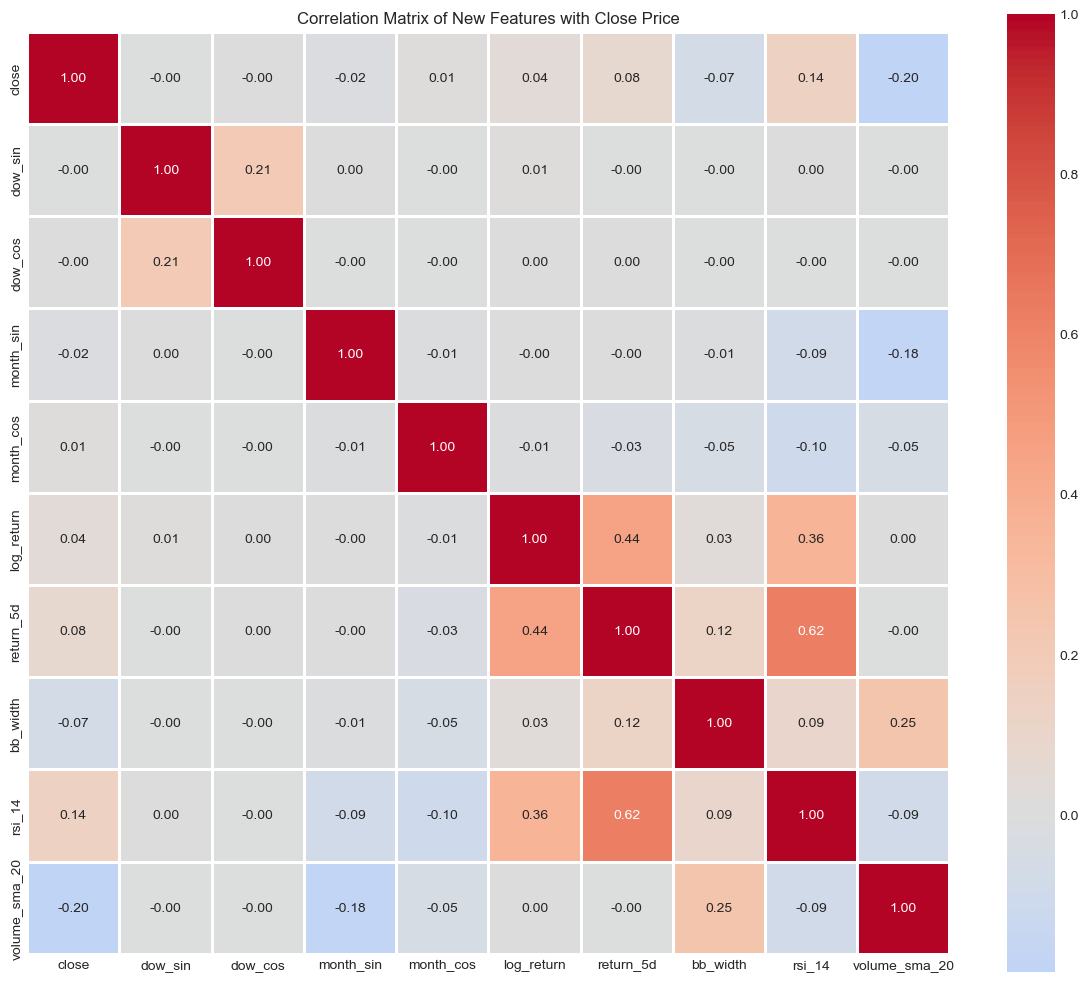

In [10]:
# Correlation matrix for new features + close price
corr_features = ['close'] + new_features
corr_matrix = hbea_advanced[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of New Features with Close Price')
plt.tight_layout()
plt.show()

## 10. Time Series Visualization

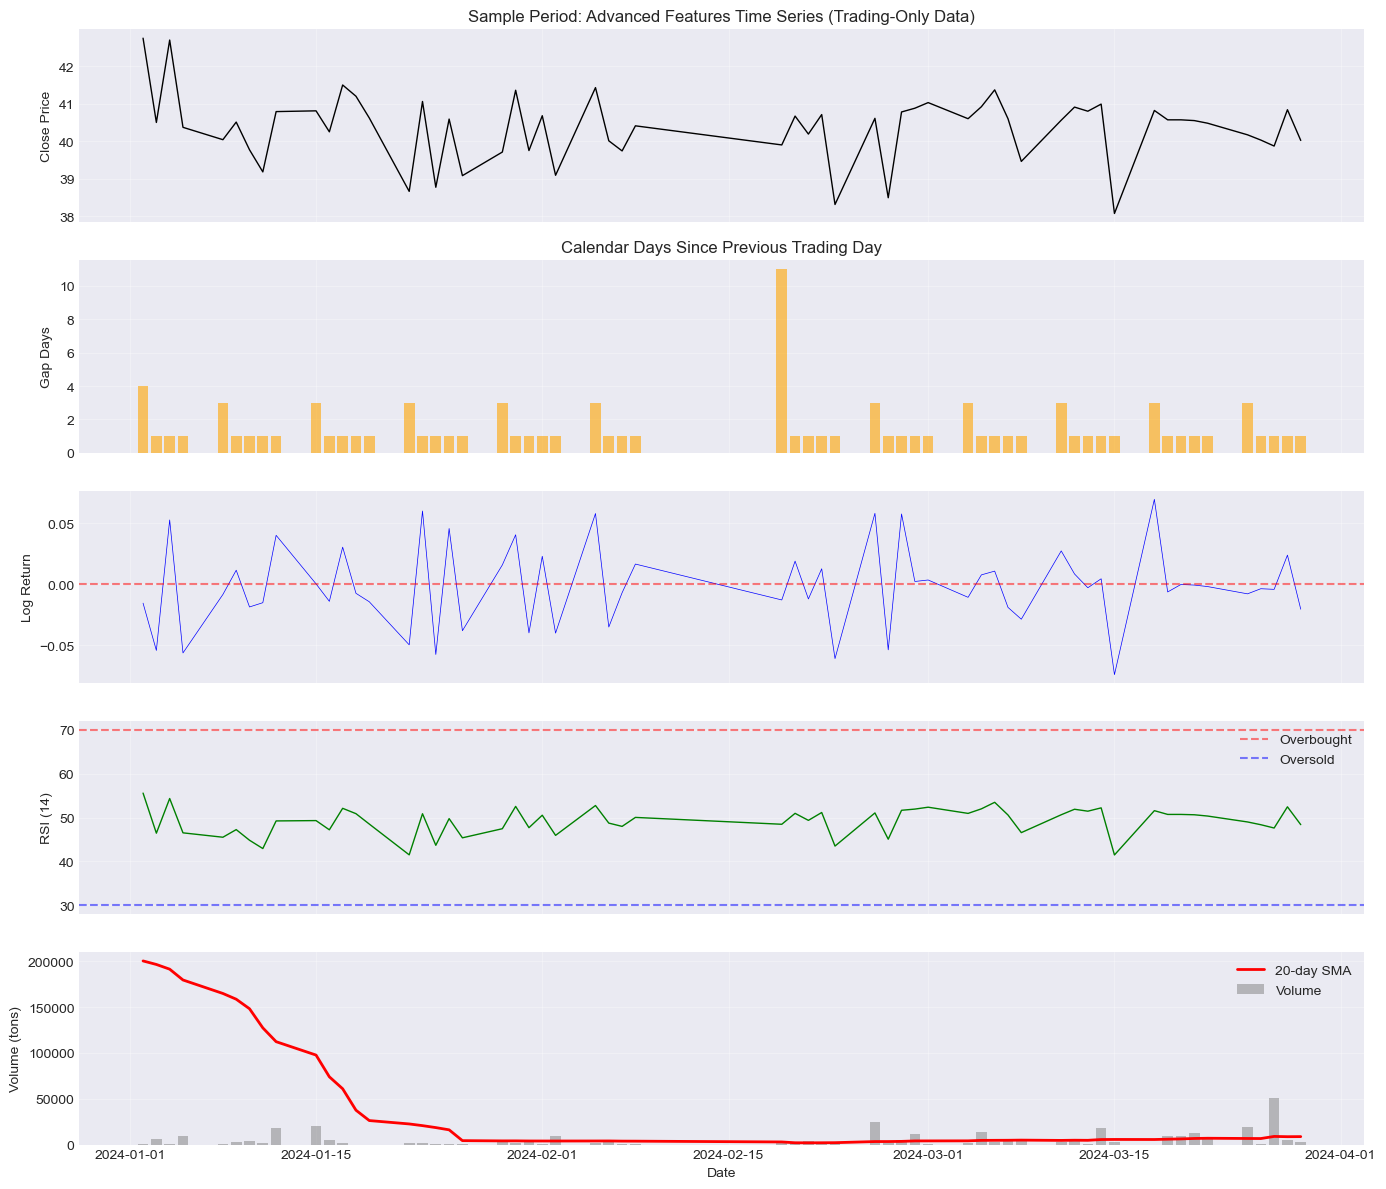

In [11]:
# Sample 3-month period for visualization
sample_start = '2024-01-01'
sample_end = '2024-03-31'
sample_data = hbea_advanced.loc[sample_start:sample_end]

if len(sample_data) > 0:
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
    
    # Close price
    axes[0].plot(sample_data.index, sample_data['close'], color='black', linewidth=1)
    axes[0].set_ylabel('Close Price')
    axes[0].set_title('Sample Period: Advanced Features Time Series (Trading-Only Data)')
    axes[0].grid(True, alpha=0.3)
    
    # Gap days (weekend/holiday indicator)
    if 'gap_days' in sample_data.columns:
        axes[1].bar(sample_data.index, sample_data['gap_days'], 
                    color='orange', alpha=0.6)
        axes[1].set_ylabel('Gap Days')
        axes[1].set_title('Calendar Days Since Previous Trading Day')
        axes[1].grid(True, alpha=0.3)
    
    # Log returns
    axes[2].plot(sample_data.index, sample_data['log_return'], 
                 color='blue', linewidth=0.5)
    axes[2].set_ylabel('Log Return')
    axes[2].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[2].grid(True, alpha=0.3)
    
    # RSI
    axes[3].plot(sample_data.index, sample_data['rsi_14'], 
                 color='green', linewidth=1)
    axes[3].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought')
    axes[3].axhline(30, color='blue', linestyle='--', alpha=0.5, label='Oversold')
    axes[3].set_ylabel('RSI (14)')
    axes[3].legend(loc='upper right')
    axes[3].grid(True, alpha=0.3)
    
    # Volume
    axes[4].bar(sample_data.index, sample_data['volume_tons'], 
                color='gray', alpha=0.5, label='Volume')
    axes[4].plot(sample_data.index, sample_data['volume_sma_20'], 
                 color='red', linewidth=2, label='20-day SMA')
    axes[4].set_ylabel('Volume (tons)')
    axes[4].set_xlabel('Date')
    axes[4].legend(loc='upper right')
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for period {sample_start} to {sample_end}")

## 11. Save Advanced LSTM Data

In [12]:
# Save the enhanced datasets
output_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_output_path = os.path.join(output_dir, "HBEA_LSTM_advanced.parquet")
gdea_output_path = os.path.join(output_dir, "GDEA_LSTM_advanced.parquet")

hbea_advanced.to_parquet(hbea_output_path)
gdea_advanced.to_parquet(gdea_output_path)

print(f"Saved HBEA advanced LSTM data: {hbea_output_path}")
print(f"Shape: {hbea_advanced.shape}")
print(f"\nSaved GDEA advanced LSTM data: {gdea_output_path}")
print(f"Shape: {gdea_advanced.shape}")

Saved HBEA advanced LSTM data: ../../02_Data_Processed/03_Feature_Engineered/HBEA_LSTM_advanced.parquet
Shape: (2679, 57)

Saved GDEA advanced LSTM data: ../../02_Data_Processed/03_Feature_Engineered/GDEA_LSTM_advanced.parquet
Shape: (2638, 57)


## 12. Final Summary

In [13]:
print("=" * 60)
print("LSTM ADVANCED FEATURE ENGINEERING COMPLETE")
print("=" * 60)

print(f"\nOriginal features: {hbea_df.shape[1]}")
print(f"New features added: {len(new_features)}")
print(f"Total features: {hbea_advanced.shape[1]}")

print("\nFeature Categories:")
print("  1. Cyclical Time (4): dow_sin, dow_cos, month_sin, month_cos")
print("  2. Gap Features (3): gap_days, post_weekend, post_holiday (from data cleaning)")
print("  3. Returns (2): log_return, return_5d")
print("  4. Volatility (1): bb_width")
print("  5. Momentum (1): rsi_14")
print("  6. Volume (1): volume_sma_20")

print("\nKey Statistics (Trading-Only Data):")
print(f"  - Total trading days: {len(hbea_advanced)}")
print(f"  - Days with trades: {(hbea_advanced['has_trade'] == True).sum()}")
print(f"  - Quiet days (no trades): {(hbea_advanced['is_quiet'] == True).sum()}")
if 'gap_days' in hbea_advanced.columns:
    print(f"  - Weekend gaps detected: {(hbea_advanced['gap_days'] == 3).sum()}")
    print(f"  - Holiday gaps detected: {(hbea_advanced['gap_days'] > 3).sum()}")
print(f"  - Average RSI: {hbea_advanced['rsi_14'].mean():.2f}")
print(f"  - Average daily log return: {hbea_advanced['log_return'].mean():.6f}")

# Show all column names
print(f"\nAll columns ({len(hbea_advanced.columns)} total):")
for i, col in enumerate(hbea_advanced.columns, 1):
    print(f"  {i:2d}. {col}")

LSTM ADVANCED FEATURE ENGINEERING COMPLETE

Original features: 48
New features added: 9
Total features: 57

Feature Categories:
  1. Cyclical Time (4): dow_sin, dow_cos, month_sin, month_cos
  2. Gap Features (3): gap_days, post_weekend, post_holiday (from data cleaning)
  3. Returns (2): log_return, return_5d
  4. Volatility (1): bb_width
  5. Momentum (1): rsi_14
  6. Volume (1): volume_sma_20

Key Statistics (Trading-Only Data):
  - Total trading days: 2679
  - Days with trades: 2610
  - Quiet days (no trades): 69
  - Weekend gaps detected: 492
  - Holiday gaps detected: 72
  - Average RSI: 50.29
  - Average daily log return: 0.000193

All columns (57 total):
   1. close
   2. vwap
   3. volume_tons
   4. turnover_cny
   5. cum_turnover_cny
   6. is_open
   7. is_quiet
   8. has_trade
   9. gap_days
  10. post_weekend
  11. post_holiday
  12. Hubei_ElectricityConsumption_Monthly_ffill_daily_15
  13. Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15
  14. Hu